# Getting started

## First step: loading the data cube

In [1]:
# import base class for the manipulation of a SITELLE spectral cube: SpectralCube
from orcs.process import SpectralCube
import pylab as pl

In [2]:
cube = SpectralCube('/home/thomas/M31_SN3.merged.cm1.1.0.hdf5')

2to3.ac74|INFO| Closing parallel processing server
2to3.ac74|INFO| shape: (2048, 2064, 840)
2to3.ac74|INFO| wavenumber calibration: True
2to3.ac74|INFO| flux calibration: True
2to3.ac74|INFO| wcs calibration: True
2to3.ac74|INFO| parallel processing closed


In [3]:
## Resetting flux calibration
# You should not do this if your cube has been freshly reduced. The cube used here as an example has an outdated flambda parameter 
# which can be reset to the latest one this way.
# Note that this calibration is computed from known instrumental parameters for ideal atmosheric conditions and modulation efficiency.
# The measured flux may thus be underestimated by more than 10%. But, in case something's really wrong in the calibration, this is a good starting point 
# which sould not be more than 15% off (and is generally around 5% off).
cube.set_flambda(cube.compute_flambda())

2to3.ac74|INFO| mean flambda config: 1.4984303888958248e-16
2to3.ac74|INFO| standard_spectrum not set: no relative vector correction computed
2to3.ac74|INFO| standard_path not set: no relative vector correction computed
2to3.ac74|INFO| standard_image not set: no absolute vector correction computed


### Exploring the deep frame

2to3.ac74|INFO| Data written as M31_SN3.deep_frame.fits in 0.20 s 


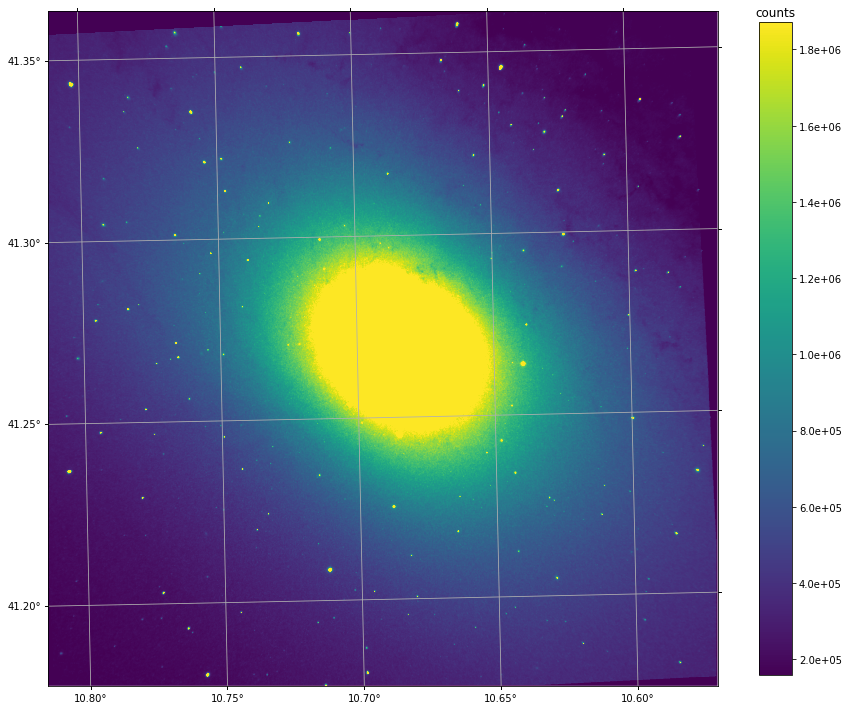

In [4]:
# explore the deep frame (in counts) 
deep = cube.get_deep_frame()
deep.imshow(perc=95, wcs=True)
pl.grid()
cb = pl.colorbar(shrink=0.8, format='%.1e')
cb.ax.set_title('counts')
deep.to_fits('M31_SN3.deep_frame.fits') # if you want to exampine it your way (e.g. with ds9 :P)

### Spectrum extraction and visualization

2to3.ac74|WARNING| No handles with labels found to put in legend.
2to3.ac74|WARNING| No handles with labels found to put in legend.


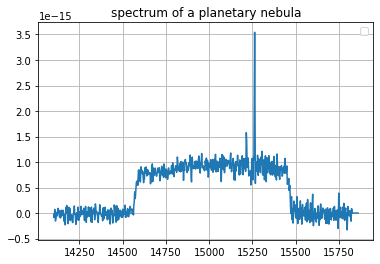

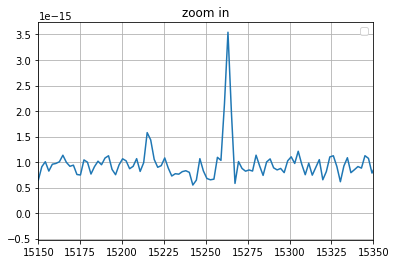

In [5]:
# extract and plot a spectrum at x=919 y=893 integrated over a radius of 2 pixels
spectrum = cube.get_spectrum(919, 893, 2) # option mean_flux 
spectrum.plot(plot_real=True)
pl.legend()
pl.grid()
pl.title('spectrum of a planetary nebula')

pl.figure()
spectrum.plot(plot_real=True)
pl.xlim((15150, 15350))
pl.legend()
pl.title('zoom in')
pl.grid()

The returned spectrum is a `RealSpectrum` object which provides many internal methods, one of which is the ability to fit directly. 

* plot: `spectrum.plot` (by default the real and the imaginary part of the spectrum are displayed, but you can dispaly only the real part with the option: `plot_imag=False`)
* fit: `spectrum.fit`

If you want to get the data and the corresponding axis as numpy.ndarray you can do it this way :

* data: `spectrum.data`
* axis: `spectrum.axis.data`

In [6]:
print('object type:', spectrum)
print('data as numpy.ndarray vector', type(spectrum.data))
print('axis (in cm-1) as numpy.ndarray vector', type(spectrum.axis.data))

object type: <orb.fft.RealSpectrum object at 0x7f4868102190>
data as numpy.ndarray vector <class 'numpy.ndarray'>
axis (in cm-1) as numpy.ndarray vector <class 'numpy.ndarray'>


### Background removal

2to3.ac74|WARNING| /home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)



Text(0.5, 1.0, 'Background around the planetary nebula')

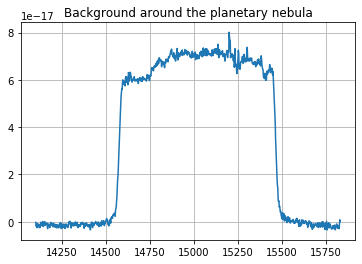

In [7]:
background = cube.get_spectrum_in_annulus(919, 893, 4, 25, median=True, mean_flux=True)
# mean_flux=True: The mean flux is returned (i.e. integrated flux / number of integrated pixels). 
#  This is important when computing a sky spectrum.
#
# median=True: When combining spectra, the median is used instead of the mean (if mean_flux is True, 
#  the computed median vector is then multiplied by the number of integrated pixels to keep with a 
#  measure of the total flux.). On large integrated regions, this operation removes outliers like 
#  isolated bright stars.
background.plot()
pl.grid()
pl.title('Background around the planetary nebula')

Text(0.5, 1.0, 'Spectrum with background removed')

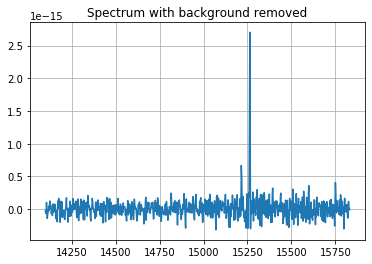

In [8]:
# Background is high below the source. It can be removed by subtracting the spectrum of a region in a an annulus around the source.

spectrum_corr = spectrum.subtract_sky(background)
# note that you didn't have to bother with the number of integrated pixels in each spectrum 
# (even if both have been integrated over different surfaces)
spectrum_corr.plot()
pl.grid()
pl.title('Spectrum with background removed')

## Second step: fitting the spectrum

* The emission lines to fit are passed by name (their wavenumber, in cm-1, could also be given directly). 
  Remember that:
  
  $\sigma [\text{cm}^{-1}] = \frac{1e7}{\lambda [\text{nm}]}$
  
  
  
* The line model is `sinc` by default because the instrumental line shape is a `sinc`. Note that the observed emission line shape is the convolution of its real shape     (e.g. a gaussian at a moderate resolution) and the instrumental line shape. i.e., fitting a `sinc` means that the observed emission line shape is considered a dirac     (infinitely narrow line) with respect to the resolution.
  
  ```python
  fmodel = 'sinc'
  ```


* The velocity of the lines is -513 km/s. It is passed with the argument:

  ```python
  pos_cov = -513`,
  pos_def = ['1','1']
  ```
  

  The velocity is considered as a covarying parameter. By default all the lines are considered to have a free velocity parameter. If we want to set the same velocity to all the lines we must set the definition of the position of eachline to the same covaying group with `pos_def = ['1','1']`.


* By default the calculated spectrum is multiplied by the filter function. But this can sometimes lead to strange results if no backgound is present. In this case the following option must be set:

  ```python
  nofilter = True
  ```

=== Fit results ===
lines: ['H3', '[NII]6584'], fmodel: sinc
iterations: 41, fit time: 6.93e-02 s
Velocity (km/s): [-508.1(1.1) -508.1(1.1)] 
Flux: [3.03(12)e-15 7.6(1.3)e-16]
Broadening (km/s): [nan +- nan nan +- nan]



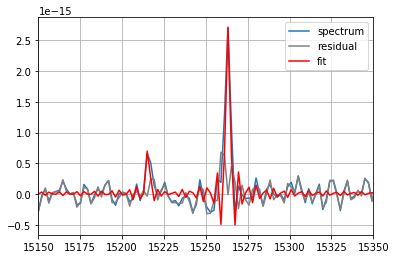

In [9]:
fit = spectrum_corr.fit(['Halpha', '[NII]6583'],
                        fmodel='sinc',
                        pos_cov=(-513,),
                        pos_def=['1', '1'],
                        nofilter=True)
# fitting results are combined into an orb.fit.OutputParams object which behaves exacly like a dict but offers some valuable methods
# for quick results plotting

print(fit) # print the most important results
spectrum_corr.plot(label='spectrum') 
fit.plot_residual(label='residual', c='gray') # plot the residual of the fit
fit.plot(label='fit', c='red') # plot the fitted vector

pl.grid()
pl.xlim((15150, 15350))
pl.legend()

# note that more can be retrived by looking into all the data provided:
# print(dict(fit))

### Ungroup the velocity parameter

We can ungroup the velocity of the emission lines by giving each line a unique group label. We can set:
  
  `pos_def=['1', '2']`
  
I this case the measured velocity must be different for both lines. But the precision will also be worsen.


=== Fit results ===
lines: ['H3', '[NII]6584'], fmodel: sinc
iterations: 49, fit time: 8.09e-02 s
Velocity (km/s): [-507.6(1.2) -516.3(4.5)] 
Flux: [3.04(12)e-15 7.8(1.2)e-16]
Broadening (km/s): [nan +- nan nan +- nan]



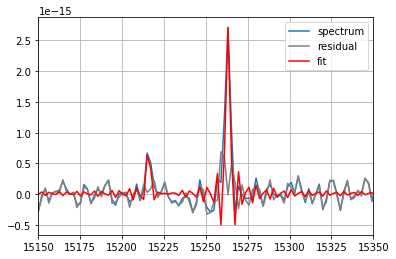

In [10]:
fit = spectrum_corr.fit(['Halpha', '[NII]6583'],
                   fmodel='sinc',
                   pos_cov=(-513, -513),
                   pos_def=['1', '2'],
                   nofilter=True)
print(fit)
spectrum_corr.plot(label='spectrum') 
fit.plot_residual(label='residual', c='gray') # plot the residual of the fit
fit.plot(label='fit', c='red') # plot the fitted vector

pl.grid()
pl.xlim((15150, 15350))
pl.legend()

### using a sincgauss model with a single broadening parameter

We can try the broadened sincgauss model (sinc instrumental function convoluted with a gaussian). We can group the broadening parameter of the emission lines by giving the same group label to the lines. We can set:
  
  ```python
  fmodel='sincgauss',
  sigma_def=['1', '1'],
  sigma_cov=20
  ```
  
I this case the measured broadening will be the same for both lines and the precision of the estimations are better.
Note that the broadening must be initialized to a nonzero value for the fit to work `sigma_cov=20`

2to3.ac74|WARNING| /home/thomas/Astro/Python/ORB/Orb/orb/fit.py:2209: UserWarning: please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans
  warnings.warn('please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans')



=== Fit results ===
lines: ['H3', '[NII]6584'], fmodel: sincgauss
iterations: 37, fit time: 1.25e-01 s
Velocity (km/s): [-506.9(1.4) -506.9(1.4)] 
Flux: [4.43(24)e-15 1.14(16)e-15]
Broadening (km/s): [27.1(1.7) 27.1(1.7)]



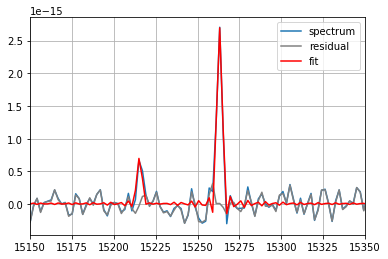

In [11]:
fit = spectrum_corr.fit(
    ['Halpha', '[NII]6583'],
    fmodel='sincgauss',
    pos_cov=(-513,),
    pos_def=['1', '1'],
    sigma_def=['1', '1'],
    sigma_cov=(20,),
    nofilter=True)
print(fit)
spectrum_corr.plot(label='spectrum') 
fit.plot_residual(label='residual', c='gray') # plot the residual of the fit
fit.plot(label='fit', c='red') # plot the fitted vector

pl.grid()
pl.xlim((15150, 15350))
pl.legend()

### Model with a high background

When the background is high (e.g. it cannot be subtracted or we are fitting emission lines of a high redshift galaxy), we can fit the backgound as a polynomial multiplied by the filter function. The order of the polynomial can be set with `poly_order` keyword.

2to3.ac74|WARNING| /home/thomas/Astro/Python/ORB/Orb/orb/fit.py:2209: UserWarning: please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans
  warnings.warn('please set a guess, or a covarying value of sigma > 0 or use a  sinc model or you might end up with nans')



=== Fit results ===
lines: ['H3', '[NII]6584'], fmodel: sincgauss
iterations: 55, fit time: 1.76e-01 s
Velocity (km/s): [-507.3(1.4) -507.3(1.4)] 
Flux: [4.34(23)e-15 1.13(16)e-15]
Broadening (km/s): [26.6(1.7) 26.6(1.7)]



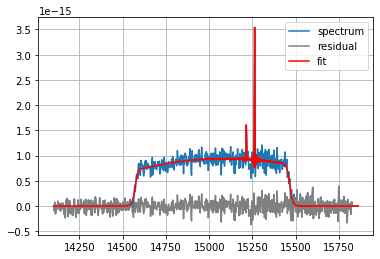

In [12]:
fit = spectrum.fit(
    ['Halpha', '[NII]6583'],
    fmodel='sincgauss',
    pos_cov=(-513,),
    pos_def=['1', '1'],
    sigma_def=['1', '1'],
    sigma_cov=(20,),
    nofilter=False,
    poly_order=2)
print(fit)
spectrum.plot(label='spectrum') 
fit.plot_residual(label='residual', c='gray') # plot the residual of the fit
fit.plot(label='fit', c='red') # plot the fitted vector

pl.grid()
pl.legend()